# Overview & Introduction

#### The objective of this blog is to provide a brief overview on creating a backtest for a simple statistical arbitrage pairs trading strategy. The content is split into two categories: research and backtesting.

### What is Statistical Arbitrage?

#### Statistical arbitrage can be defined in a few different ways, but as far as this blog is concerned, statistical arbitrage refers to the mean-reverting nature of two time-series. More specifically, that the spread between two stocks tends to mean revert to a common spread.

### What is a Pairs Trade?

#### A pairs trade is a trade that invloves two different position types, i.e. one position short and another position long. To be precise, both the long and the short position execute simultaneously by some sort of signal. For further clarification, a brief overview of short and long positions are as follows:

#### Short position: Selling shares in hope of buying those shares back at a cheaper price (at some later date). 

#### Profit arises if the share price is lower when shares are bought back. A visual of this is provided below:

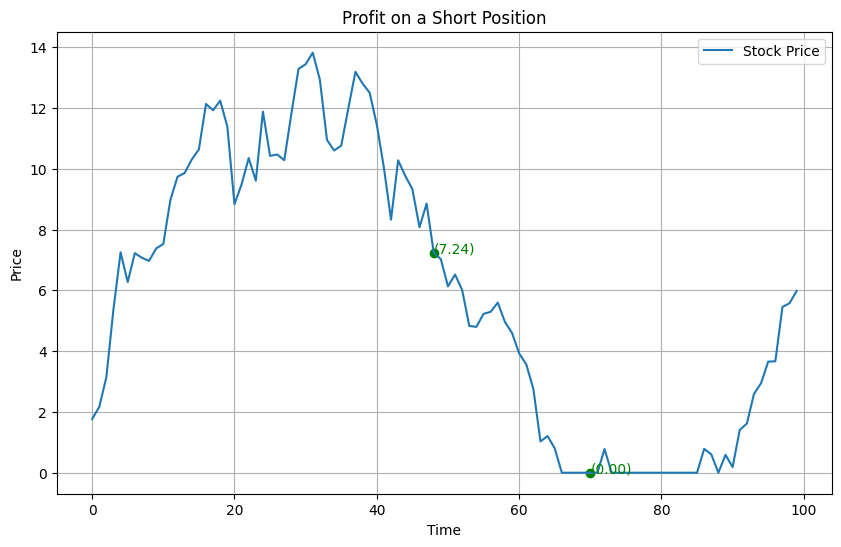

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import random

np.random.seed(0)
time = np.arange(0, 100, 1)
price = np.random.normal(0, 1, 100).cumsum()
price[price < 0] = 0
plt.figure(figsize=(10, 6))
plt.plot(time, price, label='Stock Price')
point1 = random.randint(0, len(price) - 2)
possible_points = [i for i in range(point1 + 1, len(price)) if price[i] < price[point1]]
if not possible_points:
    point2 = point1 + 1
else:
    point2 = random.choice(possible_points)

plt.scatter([time[point1], time[point2]], [price[point1], price[point2]], color='green')
plt.text(time[point1], price[point1], f'({price[point1]:.2f})', color='green')
plt.text(time[point2], price[point2], f'({price[point2]:.2f})', color='green')

plt.title('Profit on a Short Position')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Loss arises if the share price is higher when shares are bought back. A visual of this is provided below:

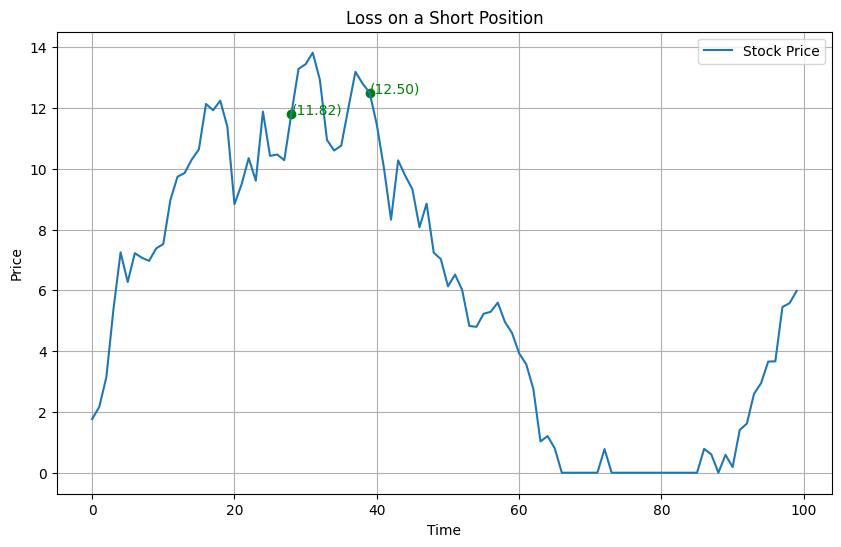

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import random

np.random.seed(0)
time = np.arange(0, 100, 1)
price = np.random.normal(0, 1, 100).cumsum()
price[price < 0] = 0
plt.figure(figsize=(10, 6))
plt.plot(time, price, label='Stock Price')
point1 = random.randint(0, len(price) - 2)
possible_points = [i for i in range(point1 + 1, len(price)) if price[i] > price[point1]]
if not possible_points:
    point2 = point1 + 1
else:
    point2 = random.choice(possible_points)

plt.scatter([time[point1], time[point2]], [price[point1], price[point2]], color='green')
plt.text(time[point1], price[point1], f'({price[point1]:.2f})', color='green')
plt.text(time[point2], price[point2], f'({price[point2]:.2f})', color='green')

plt.title('Loss on a Short Position')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Long position: Buying shares in hope of selling those shares at a more expensive price (at some later date).

#### Profit arises if the share price is higher when shares are sold. A visual of this is provided below:

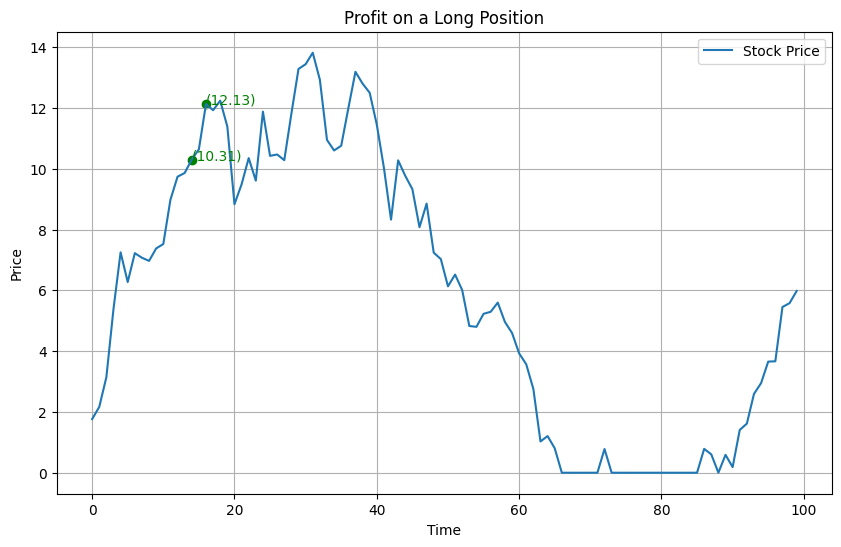

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import random

np.random.seed(0)
time = np.arange(0, 100, 1)
price = np.random.normal(0, 1, 100).cumsum()
price[price < 0] = 0
plt.figure(figsize=(10, 6))
plt.plot(time, price, label='Stock Price')
point1 = random.randint(0, len(price) - 2)
possible_points = [i for i in range(point1 + 1, len(price)) if price[i] > price[point1]]
if not possible_points:
    point2 = point1 + 1
else:
    point2 = random.choice(possible_points)

plt.scatter([time[point1], time[point2]], [price[point1], price[point2]], color='green')
plt.text(time[point1], price[point1], f'({price[point1]:.2f})', color='green')
plt.text(time[point2], price[point2], f'({price[point2]:.2f})', color='green')

plt.title('Profit on a Long Position')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Loss arises if the share price is lower when shares are sold. A visual of this is provided below:

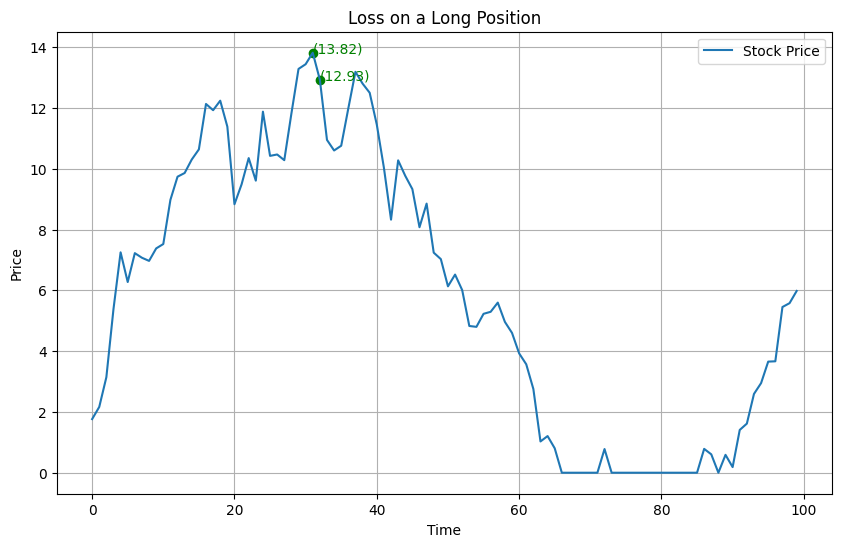

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import random

np.random.seed(0)
time = np.arange(0, 100, 1)
price = np.random.normal(0, 1, 100).cumsum()
price[price < 0] = 0
plt.figure(figsize=(10, 6))
plt.plot(time, price, label='Stock Price')
point1 = random.randint(0, len(price) - 2)
possible_points = [i for i in range(point1 + 1, len(price)) if price[i] > price[point1]]
if not possible_points:
    point2 = point1 + 1
else:
    point2 = random.choice(possible_points)

plt.scatter([time[point1], time[point2]], [price[point1], price[point2]], color='green')
plt.text(time[point1], price[point1], f'({price[point1]:.2f})', color='green')
plt.text(time[point2], price[point2], f'({price[point2]:.2f})', color='green')

plt.title('Loss on a Long Position')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Research

#### Like every other problem, we must first start by conducting research. For this blog, I'll start by analyzing a list of some of the top car manufacturing companies. Why? Because my intuition leads me to beleive that since all of these companies compete in the same indsutry, their stock prices must have some sort of correlation. To put my intuition to the test, we'll run a Pairwise Engle-Granger test on every combination of stocks in the list of top car manufacturing companies. A Pairwise Engle-Granger test uses a two-step approach in analyzing cointegration between two time series. First, it regresses one non-stationary time series on another. The purpose of this is to analyze the residuals on the regression, since these residuals represent the error or the deviation from the estimated linear relationship between the two time series. Next, we test for stationarity through an Augmented Dickey-Fuller (ADF) test. The ADF test is used to check for a unit root in a time series, which is indicative of non-stationarity. If the p-value from the ADF test is less than 0.05, we can reject the null-hypothesis and conclude that there is indeed evidence of stationarity. The following code snippet runs a Pairwise Engle-Granger test and displays a table of ADF test p-values:

In [59]:
# Import the packages needed for this task:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning) 

# Initialize the top car manufacturing companies into a list (using their ticker symbols):
stocks = ['TM', 'GM', 'F', 'HMC', 'NSANY', 'HYMTF']

# Download the data for each stock in the list:
stock_data = {stock: yf.download(stock, period='10y')['Close'] for stock in stocks}

# Initialize a DataFrame to store the p-values:
p_values = pd.DataFrame(index=stocks, columns=stocks)

# Perform a pairwise Engle-Granger test on each possible pair of stocks in the list:
for pair in itertools.combinations(stocks, 2):
    # Regress one stock on the other:
    Y = stock_data[pair[0]].dropna()
    X = stock_data[pair[1]][Y.index]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    residuals = model.resid

    # Apply an Augmented Dickey-Fuller test on the residuals:
    adf_result = adfuller(residuals)
    p_value = adf_result[1]

    # Store the p-value into the DataFrame we previously made:
    p_values.loc[pair[0], pair[1]] = p_value
    p_values.loc[pair[1], pair[0]] = p_value

# Output the table of p-values (green highlight: p-value < 0.05, red highlight: p-value > 0.05):
def highlight_significant(val):
    color = 'green' if val < 0.05 else 'red'
    return 'color: %s' % color
styled_p_values = p_values.style.map(highlight_significant)
styled_p_values

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,TM,GM,F,HMC,NSANY,HYMTF
TM,nan,0.952181,0.961701,0.978087,0.586407,0.960667
GM,0.952181,nan,0.215115,0.110907,0.073826,0.105504
F,0.961701,0.215115,nan,0.190942,0.099532,0.035555
HMC,0.978087,0.110907,0.190942,nan,0.022690,0.000497
NSANY,0.586407,0.073826,0.099532,0.022690,nan,0.924718
HYMTF,0.960667,0.105504,0.035555,0.000497,0.924718,nan


#### It is reassuring to see p-values below 0.05, as this implies evidence of stationarity/cointegration! Now, we will proceed forward with HMC (Honda Motor Company) and HYMTF (Hyundai Motor Company) for further testing. Since our previous ADF test used residuals, let's get a more accurate p-value from the ADF test by using the spread between HMC and MYMTF price data:

In [4]:
# Download HMC and MYMTF price data:
hmc_data = yf.download('HMC', period='10y')['Close']
hymtf_data = yf.download('HYMTF', period='10y')['Close']

# Calculate the spread:
spread = hymtf_data - hmc_data

# Perform ADF test on the spread:
adf_result = adfuller(spread.dropna())

# Print test results:
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ADF Statistic: -2.91392128175283
p-value: 0.0437529265963586
Critical Value (1%): -3.432976825339513
Critical Value (5%): -2.862700515844509
Critical Value (10%): -2.5673877878037974


#### Our p-value is still below 0.05! Additionally, our ADF statistic is less than the critical value at both the 5% and 10% level, which is more evidence of mean-reversion. To proceed forward, lets plot the price data for both stocks. The Yahoo Finance package, yfinance, gives us access to various price data, but to keep things simple, we'll stick with the 'Close' data when analyzing stock prices:

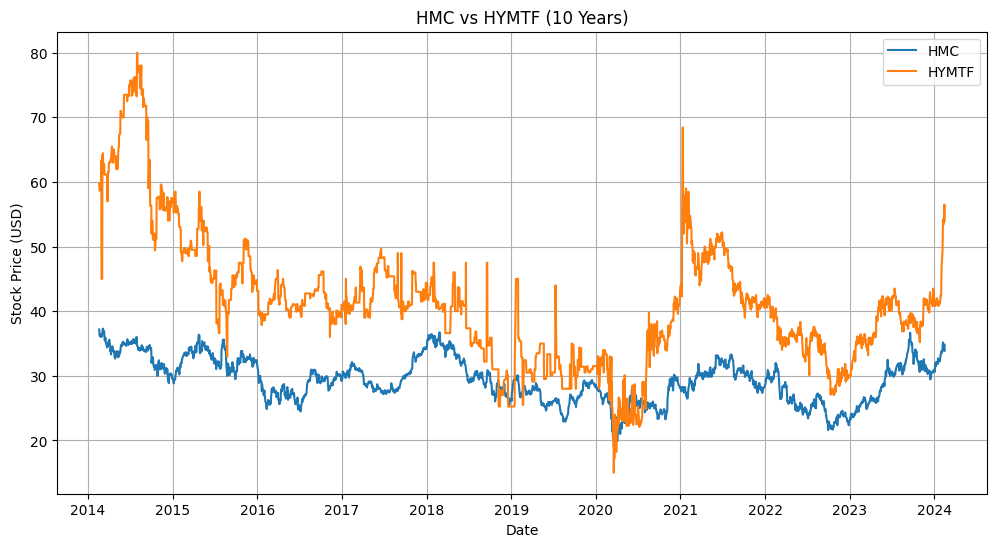

In [5]:
# Import the packages needed for this task:
import matplotlib.pyplot as plt

# Plot the 'Close' data:
plt.figure(figsize=(12, 6))
plt.plot(hmc_data, label='HMC')
plt.plot(hymtf_data, label='HYMTF')
plt.title('HMC vs HYMTF (10 Years)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

#### Next, lets plot the previously calculated spread between the stock prices for a further visualization:

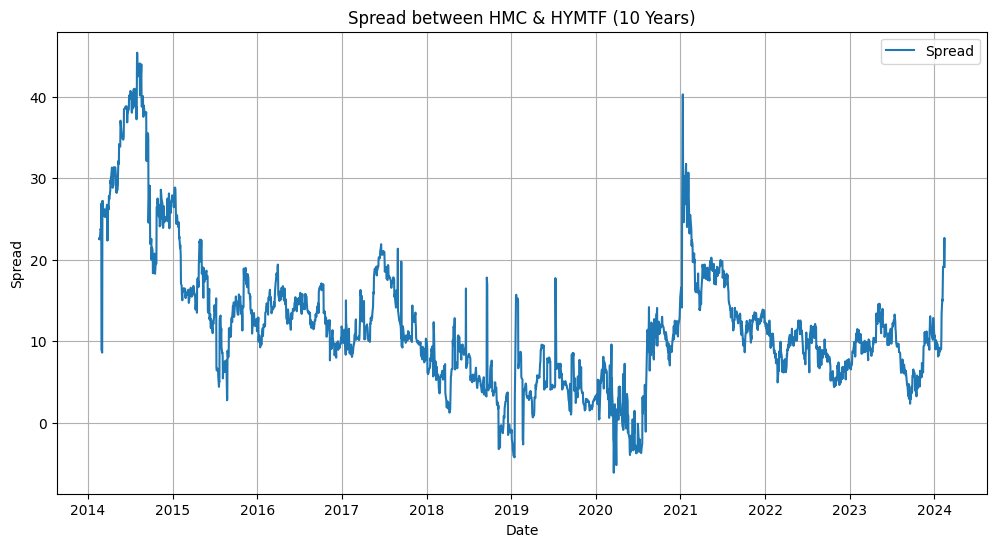

In [6]:
# Plot the spread:
plt.figure(figsize=(12, 6))
plt.plot(spread, label='Spread')
plt.title('Spread between HMC & HYMTF (10 Years)')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

#### The spread looks rather stationary, which serves as an additional sanity check for our prior claim. One last test we should implement is the Spearman Rank Coefficient, which is used to analyze the measure of statistical dependence between two time series. 

In [7]:
# Import the packages needed for this task:
from scipy.stats import spearmanr

# Calculate the daily returns:
hmc_returns = hmc_data.pct_change().dropna()
hymtf_returns = hymtf_data.pct_change().dropna()

# Compute Spearman Rank Correlation Coefficient:
spearman_corr, p_value = spearmanr(hmc_returns, hymtf_returns)

# Display the results:
print(f"Spearman Rank Correlation Coefficient: {spearman_corr:.3f}")
print(f"P-value: {p_value:.3f}")

Spearman Rank Correlation Coefficient: 0.148
P-value: 0.000


#### Even though the Spearman Rank Correlation Coefficient is rather weak, a p-value of zero is considered to be statistically significant. There are still many more statistical approaches we can take to further determine the stationarity between these two time series, but I beleive we have seen strong enough evidence to proceed forward to backtesting.

# Backtesting

#### The remainder of this blog will entail backtesting our previously researched statistical arbitrage pairs trade. Instead of using a typical z-score signal for opening and closing trade positions, I'd like to use Bollinger Bands instead. Bollinger Bands consist of three characteristics, visualized by three distinct lines on a graph. I'd also like to mention that since our strategy is centered around mean-reversion, we aren't focused on the actual stock prices as much as we are on the spread between them. The first characteristic of Bollinger Bands is the rolling mean. Since our strategy consists of a statistical arbitrage pairs trade, the rolling/moving mean will be taken from the spread. The next characteristic of Bollinger Bands is the upper band. The upper band is computed by adding a standard deviation multiplier (typically set to 2) to the rolling/moving mean. The idea of the upper band is to capture the upper level of the spread range. The final characteristic of Bollinger Bands is the lower band. Opposite to that of the upper band, the lower band is computed by subtracting a standard deviation multiplier (also, typically set to 2) from the rolling/moving mean. The idea of the lower band is to capture the lower level of the spread range. The way that Bollinger Bands are used to execute trades are as follows:

#### An open position occurs when the spread crosses either the upper band or the lower band. If the spread crosses the upper band, it implies that the spread has surpased our previously defined 'upper level of the spread range.' This means that the spread has grown past our ideal spread range, hopefully resulting in future mean-reversion. Since we believe that the spread is stationary, we're going to short HYMTF (the stock that has drastically risen in price/value) and long HMC (the stock that has drastically fallen in price/value). The goal here is to profit on the overpriced HYMTF stock as well as profit on the underpriced HMC stock. Now, this position will remain open until the spread crosses back over the rolling mean, in which case we will close the previously opened position by buying back the HYMTF shares we initially sold (when we went short HYMTF) and selling the HMC shares we initially bought (when we went long HMC). After a trade position has been closed, we are free to enter another open position based on whether the spread crosses the upper band or the lower band. If the spread crossed the lower band, it implies that the spread has surpased our previously defined 'lower level of the spread range.' Opposite to that of the upper band position, this means that the spread has shrunk past our ideal spread range, hopefully resulting in future mean-reversion. This pairs trade is the exact oposite of the one executed at the upper band, i.e., we now long HYMTF (the stock that has drastically fallen in price/value) and short HMC (the stock that has drastically risen in price/value). Once the spread crosses back over the rolling mean, we exit/close this position buy selling the HYMTF shares we initially bought (when we went long HYMTF) and buying back the HMC shares we initially sold (when we went short HMC). In a backtest, this process repeats until the end of the designated time-period. When live trading, this process repeats indefinitely until the trading algorithm is terminated.

#### Now, lets break down the backtest. First, lets start by gathering our stock data, calculating the spread, and calculating the Bollinger Bands. Lets start by setting the Bollinger Band parameters to a rolling window of 8 and a standard deviation multiplier of 0.8 for both the upper and lower bands. Optimizing Bollinger Band parameters is something that we can explore at a later date.

In [54]:
# Import the packages needed for this task:
import yfinance as yf
import pandas as pd

# Download HMC and MYMTF price data:
hmc_data = yf.download('HMC', period='10y')['Close']
hymtf_data = yf.download('HYMTF', period='10y')['Close']

# Calculate the spread:
spread = hymtf_data - hmc_data

# Bollinger Band Parameters:
rolling_window = 8     # This is used for determining how many days ahead to use to calculate the rolling mean
rolling_mean = (spread.rolling(window=rolling_window).mean()).dropna()
rolling_std = (spread.rolling(window=rolling_window).std()).dropna()
upper_band = rolling_mean + (rolling_std * 0.8)
lower_band = rolling_mean - (rolling_std * 0.8)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


#### Next, we're going to filter through our spread index and analyze when the spread crosses the upper band, lower band, and back over rolling mean. At each position, we're going to append the trade information to a DataFrame and then use this DataFrame later to calculate realized profit and loss. Note that the information we need to append at each position, upper and lower, includes: date, action (i.e., open or close position), type (i.e., lower band cross or upper band cross), share quantity for both stocks as well as share prices for both stocks.

In [55]:
# Capital to allocate to each trade in the pairs trade:
money_per_trade = 50000

# Convert capital to shares:
hmc_share_quant = money_per_trade/hmc_data
hymtf_share_quant = money_per_trade/hymtf_data

daily_returns = []
trade_log = []
position_open = False
position_type = None

for date, current_spread in spread.items():
    if date not in hmc_data.index or date not in upper_band.index:
        continue
    hmc_price = hmc_data.get(date, None)
    hymtf_price = hymtf_data.get(date, None)
    lower_band_value = lower_band[date]
    upper_band_value = upper_band[date]
    mean_value = rolling_mean[date]
    hmc_shares = hmc_share_quant.get(date, None)
    hymtf_shares = hymtf_share_quant.get(date, None)
    if current_spread < lower_band_value and not position_open:
        # Open a pairs trade position (short HMC, long HYMTF)
        trade_log.append({
            'Date': date,
            'Action': 'Open Position',
            'Type': 'lower',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = True
        position_type = 'lower'
        
    elif current_spread > upper_band_value and not position_open:
        # Open a different pairs trade position (long HMC, short HYMTF)
        trade_log.append({
            'Date': date,
            'Action': 'Open Position',
            'Type': 'upper',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = True
        position_type = 'upper'
    
    elif current_spread > mean_value and position_open and position_type == 'lower':
        # Close position opened at lower band
        trade_log.append({
            'Date': date,
            'Action': 'Close Position',
            'Type': 'lower',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = False
        
    elif current_spread < mean_value and position_open and position_type == 'upper':
        # Close position opened at upper band
        trade_log.append({
            'Date': date,
            'Action': 'Close Position',
            'Type': 'upper',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = False

# Save the trade log DataFrame to a csv file for a visual sanity check:
trade_log_df = pd.DataFrame(trade_log)
trade_log_df.to_csv('tradelog.csv')

#### Now that we have our trade log DataFrame with all of the information that we need, lets proceed forward and calculate realized profit and loss:

In [56]:
# Iterate through rows in our trade log DataFrame and calcule the pnl:
total_return = 0
open_position = None
close_position_dates = []
close_position_returns = []
for index, trade in trade_log_df.iterrows():
    if trade['Action'] == 'Open Position':
        open_position = trade
    elif trade['Action'] == 'Close Position' and open_position is not None:
        close_position = trade
        close_position_dates.append(trade['Date'])
        if open_position['Type'] == 'lower':
            hmc_profit_loss = (open_position['HMC_Price'] - trade['HMC_Price']) * (open_position['HMC_Shares'])
            hymtf_profit_loss = (trade['HYMTF_Price'] - open_position['HYMTF_Price']) * (open_position['HYMTF_Shares'])
        elif open_position['Type'] == 'upper':
            hmc_profit_loss = (trade['HMC_Price'] - open_position['HMC_Price']) * (open_position['HMC_Shares'])
            hymtf_profit_loss = (open_position['HYMTF_Price'] - trade['HYMTF_Price']) * (open_position['HYMTF_Shares'])

        total_profit_loss = hmc_profit_loss + hymtf_profit_loss
        total_return += total_profit_loss
        close_position_returns.append(total_profit_loss)

profit_loss_df = pd.DataFrame(close_position_returns, index=close_position_dates, columns=['Profit/Loss'])
profit_loss_df.to_csv('returns.csv')

#### Let's now plot cumulative realized profit and loss on a graph over our 10-year time period. Each circle marker on the graph represents a close position where realized profit and loss is calculated:

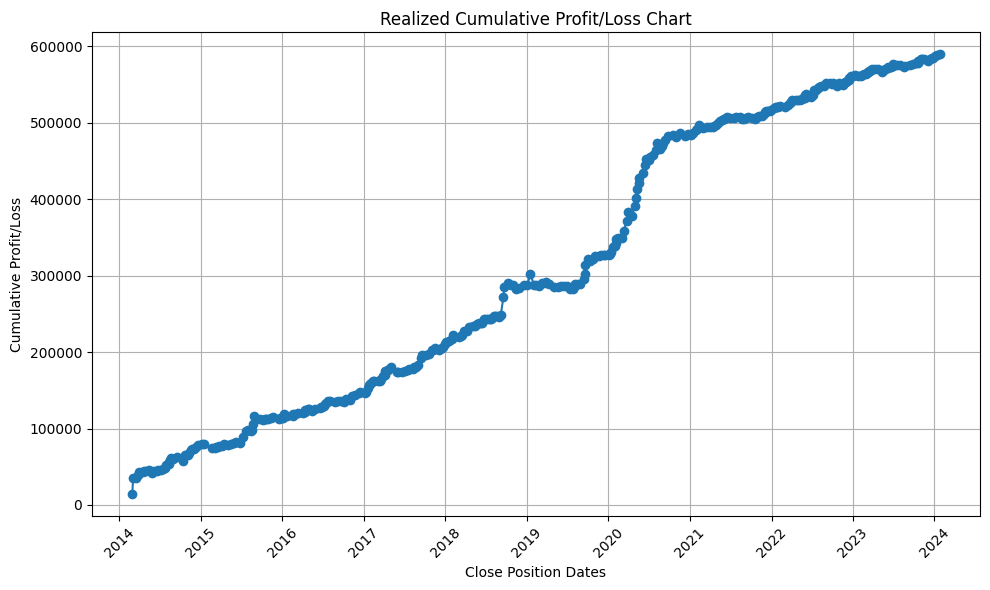

In [57]:
# Import the packages needed for this task:
import matplotlib.pyplot as plt

# Calculate the cumulative profit and loss:
profit_loss_df['Cumulative PnL'] = profit_loss_df['Profit/Loss'].cumsum()

# Plot:
plt.figure(figsize=(10, 6))
plt.plot(profit_loss_df.index, profit_loss_df['Cumulative PnL'], marker='o', linestyle='-')
plt.title('Realized Cumulative Profit/Loss Chart')
plt.xlabel('Close Position Dates')
plt.ylabel('Cumulative Profit/Loss')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Sharpe Ratio (SR): A way to measure risk-adjusted returns on a strategy. For now, the general goal is anything greater than a SR of 2. In the following code snippet, we calculate annualized SR for this statistical pairs trading strategy. Then, we plot this on a graph alongside the average SR over the 10-year period that we've been working with.

Annual Sharpe Ratio:
 Year
2014    2.833045
2015    1.765289
2016    3.478597
2017    4.562692
2018    2.791049
2019    1.364615
2020    5.518979
2021    3.217659
2022    3.992698
2023    2.646463
2024    0.719495
Name: Returns, dtype: float64

Number of Trades per Year:
 Year
2014    32
2015    31
2016    33
2017    39
2018    35
2019    32
2020    37
2021    38
2022    41
2023    39
2024     3
dtype: int64

Average Sharpe Ratio: 2.9900528961976645


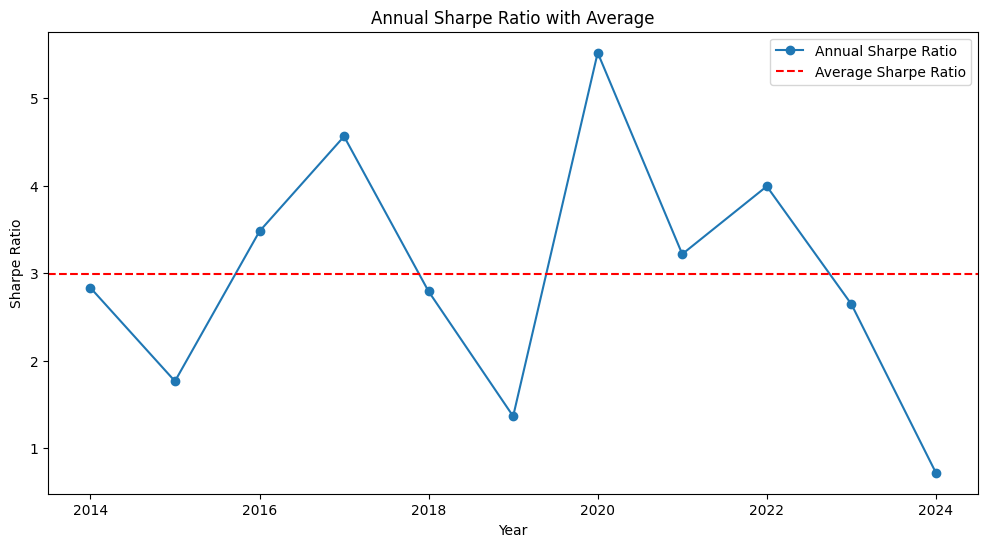

In [58]:
# Import the packages needed for this task:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert the PnL to returns:
capital = 100000  # Adjust this as per your initial capital
profit_loss_df['Returns'] = profit_loss_df['Profit/Loss'] / capital

# Group the data by year using the index:
profit_loss_df['Year'] = profit_loss_df.index.year

# Count the trades per year and calculate the average:
trades_per_year = profit_loss_df.groupby('Year').size()
average_trades_per_year = trades_per_year.mean()

# Calculate the annual return as well as the standard deviation:
annual_returns = profit_loss_df.groupby('Year')['Returns'].sum()
annual_std_dev = profit_loss_df.groupby('Year')['Returns'].std() * np.sqrt(average_trades_per_year)
annual_risk_free_rate = 0.01

# Calculate the annual Sharpe Ratio:
annual_sharpe_ratio = (annual_returns - annual_risk_free_rate) / annual_std_dev

# Calculate the average Sharpe Ratio:
average_sharpe_ratio = annual_sharpe_ratio.mean()


# Print info:
print("Annual Sharpe Ratio:\n", annual_sharpe_ratio)
print("\nNumber of Trades per Year:\n", trades_per_year)
print("\nAverage Sharpe Ratio:", average_sharpe_ratio)

# Plot:
plt.figure(figsize=(12, 6))
plt.plot(annual_sharpe_ratio, label='Annual Sharpe Ratio', marker='o')
plt.axhline(y=average_sharpe_ratio, color='r', linestyle='--', label='Average Sharpe Ratio')
plt.title('Annual Sharpe Ratio with Average')
plt.xlabel('Year')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()

# Conclusion

#### This blog covers the basic finance involved with statistical arbitrage pairs trading, research, and surface-level backtesting. As we can see, there are still many things that we still need to consider and analyze. This blog doesn't take into account fees when calculating realized profit and loss. We also don't calculate unrealized profit and loss, nor do we analyze the daily trade volume of both stocks to determine what share quantities this strategy can support. It might also be beneficial to analyze market impact, i.e., how much daily trade volume we can participate with before disrupting our own signal (spread). Lastly, our sharpe ratio is calculated on a trade-basis and not on a daily-return basis, which is something to keep in the back of our mind when interpreting these results.

#### Overall, I believe that this is a great starting spot when it comes to statistical arbitrage pairs trading.

#### Have any questions, concerns, thoughts, etc.? Feel free to contact me (contact information available on website homepage).